# Getting Started with AuctionGym
## Effects of Bid Shading in First-Price Auctions

AuctionGym has several configuration options that detail the type of auction, how bidders behave, and how confounded the contextual information is that bidders observe. To avoid clutter, we define these in configuration files.
For the purposes of this introductory notebook, we will ignore some aspects such as repeated runs.

We parse an existing file, detailing a first-price auction with oracle bidders.
We will look into the effects of bid shading on the auctioneer's revenue, social welfare and surplus.
For this, we repeat simulated experiments with the same set of bidders, changing how their bidding strategy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from main import parse_config, instantiate_agents, instantiate_auction
from tqdm.notebook import tqdm

In [2]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values,\
num_runs, max_slots, embedding_size, embedding_var,\
obs_embedding_size = parse_config('../config/FP_DM_Oracle.json')

In [3]:
def run_repeated_auctions():
    # Placeholders for output
    auction_revenue = []
    social_welfare = []
    social_surplus = []
    
    # Instantiate Agent and Auction objects
    agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)

    # Instantiate Auction object
    auction, num_iter, rounds_per_iter, output_dir =\
        instantiate_auction(rng,
                            config,
                            agents2items,
                            agents2item_values,
                            agents,
                            max_slots,
                            embedding_size,
                            embedding_var,
                            obs_embedding_size)

    # Run repeated auctions
    # This logic is encoded in the `simulation_run()` method in main.py
    for i in tqdm(range(num_iter)):

        # Simulate impression opportunities
        for _ in range(rounds_per_iter):
            auction.simulate_opportunity()

        # Log 'Gross utility' or welfare
        social_welfare.append(sum([agent.gross_utility for agent in auction.agents]))

        # Log 'Net utility' or surplus
        social_surplus.append(sum([agent.net_utility for agent in auction.agents]))
        
        # Update agents (does nothing in this example, as we have truthful oracles)
        # Clear running metrics
        for agent_id, agent in enumerate(auction.agents):
            agent.update(iteration=i)
            agent.clear_utility()
            agent.clear_logs()

        # Log revenue
        auction_revenue.append(auction.revenue)
        auction.clear_revenue()
        
    # Rescale metrics per auction round
    auction_revenue = np.array(auction_revenue) / rounds_per_iter
    social_welfare = np.array(social_welfare) / rounds_per_iter
    social_surplus = np.array(social_surplus) / rounds_per_iter
    
    return auction_revenue, social_welfare, social_surplus

In [ ]:
shaded_revenue, shaded_welfare, shaded_surplus = run_repeated_auctions()

In [5]:
def set_truthful_bidders(agent_configs):
    for agent_config in agent_configs:        
        agent_config['bidder'] = {
            'type': 'TruthfulBidder',
            'kwargs': {}
        }
set_truthful_bidders(agent_configs)
truthful_revenue, truthful_welfare, truthful_surplus = run_repeated_auctions()

  0%|          | 0/20 [00:00<?, ?it/s]

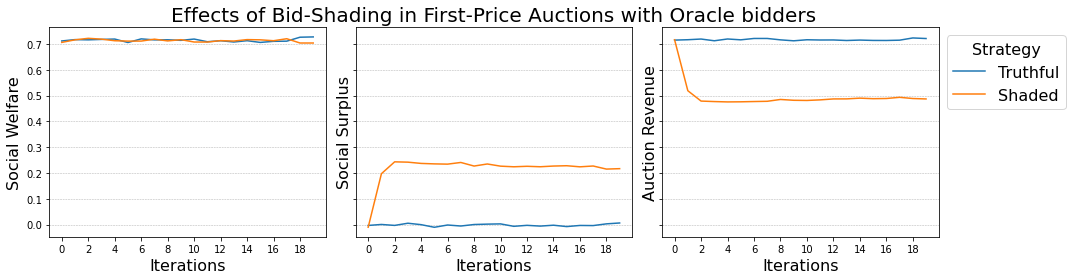

In [6]:
fontsize=16
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(15,4))

axes[0].plot(truthful_welfare, label=f'Truthful')
axes[1].plot(truthful_surplus, label=f'Truthful')
axes[2].plot(truthful_revenue, label=f'Truthful')

axes[0].plot(shaded_welfare, label=f'Shaded')
axes[1].plot(shaded_surplus, label=f'Shaded')
axes[2].plot(shaded_revenue, label=f'Shaded')

axes[1].set_title('Effects of Bid-Shading in First-Price Auctions with Oracle bidders', fontsize=fontsize+4)

for i in range(3):
    axes[i].set_xlabel('Iterations', fontsize=fontsize)
    axes[i].set_xticks(list(range(0,len(truthful_revenue),2)))
    axes[i].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    
axes[0].set_ylabel('Social Welfare', fontsize=fontsize)
axes[1].set_ylabel('Social Surplus', fontsize=fontsize)
axes[2].set_ylabel('Auction Revenue', fontsize=fontsize)

legend = axes[2].legend(loc='upper left',
                        bbox_to_anchor=(1.0, 1.0),
                        fontsize=fontsize)
legend.set_title('Strategy', prop={'size': fontsize})
fig.tight_layout()

plt.show()

The leftmost plot shows social welfare (the sum of generated welfare over all participants in the auction).
Whether participants shade their bids (or not) does not have affect welfare: indeed, the value that is generated by the ads that are shown remains unchanged.

The middle plot shows social surplus.
Bidding truthfully in a first-price auction gives an expected surplus of 0.
As bidders start to shade their bids, we can see that bidders succesfully generate surplus.

The rightmost plot shows revenue for the auctioneer.
When bidders bid truthfully, the monetary value for all generated welfare goes to the auctioneer.
As bidders start to shade their bids, we can see that revenue diminishes as surplus increases.